<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

Adapted from the excellent paper by Jinsung Yoon, Daniel Jarrett, and Mihaela van der Schaar:  

[Time-series Generative Adversarial Networks](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks),  

Neural Information Processing Systems (NeurIPS), 2019.



- Last updated Date: April 24th 2020

- [Original code](https://bitbucket.org/mvdschaar/mlforhealthlabpub/src/master/alg/timegan/) author: Jinsung Yoon (jsyoon0823@gmail.com)

In [393]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data-kfs/long_format.csv
/kaggle/input/interpolated-data/interpolated_data.csv
/kaggle/input/real-dataset/test_data.parquet
/kaggle/input/real-dataset/train_data.parquet
/kaggle/input/my-dataset/test_tbi_data.csv
/kaggle/input/my-dataset/final_preprocessed_tbi_data.csv
/kaggle/input/my-dataset/train_tbi_data.csv
/kaggle/input/my-dataset-no-log/final_preprocessed_tbi_data_no_log.csv
/kaggle/input/my-dataset-no-log/test_tbi_data_no_log.csv
/kaggle/input/my-dataset-no-log/train_tbi_data_no_log.csv
/kaggle/input/time-series-data/stock_data.csv
/kaggle/input/time-series-data/energy_data.csv


In [442]:
print(tf.__version__)
print(tf.keras.__version__)

2.16.1
3.3.3


In [394]:
import warnings
warnings.filterwarnings('ignore')

In [395]:
import os
import json
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from tqdm import tqdm
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input, Dropout, LSTM
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import l2
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.metrics import AUC
from matplotlib.ticker import FuncFormatter

In [396]:
# Setup GPU
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

if gpu_devices:
    print('Using GPU')
    
    for i in range(len(gpu_devices)):
        tf.config.experimental.set_memory_growth(gpu_devices[i], True) # Allocated only one GPU memory for this training
else:
    print('Using CPU')

Using CPU


## Experiment path

In [397]:
results_path = Path('time_gan')  #instantiates a concrete path for the platform the code is running on.
if not results_path.exists():
    results_path.mkdir()

In [398]:
experiment = 0

In [399]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

## Normalize Data

In [400]:
df = pd.read_csv('../input/data-kfs/long_format.csv') # Load data as numpy array and drop column headers
#df = pd.read_csv('../input/interpolated-data/interpolated_data.csv')

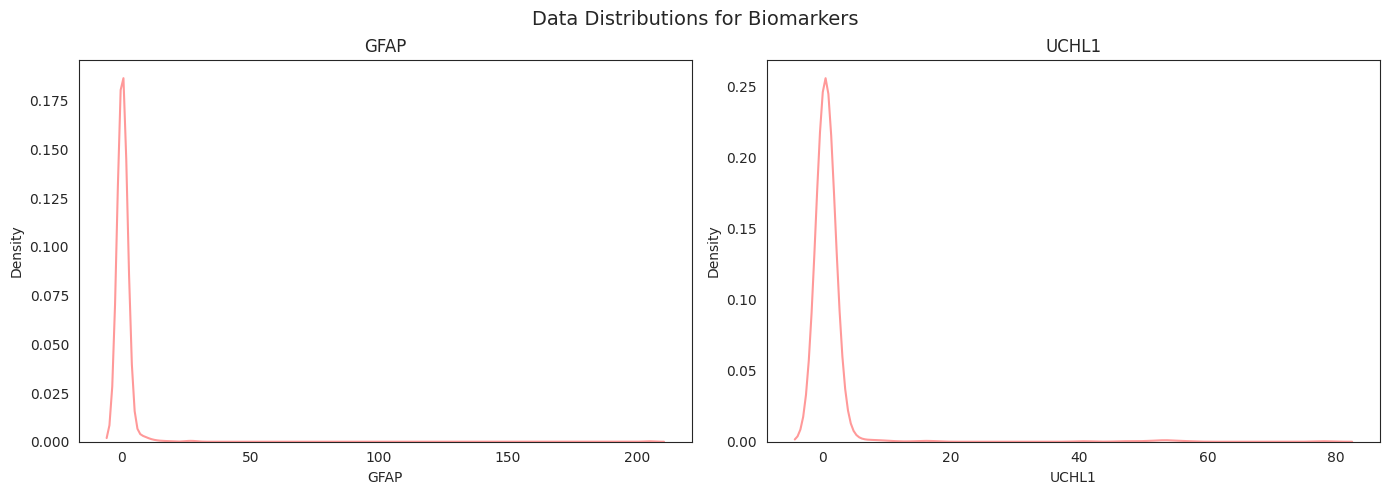

In [401]:
import seaborn as sns

fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
sns.kdeplot(data=df['GFAP'], ax=axes[0], color='red', alpha=0.4)

axes[0].set_title('GFAP')

sns.kdeplot(data=df['UCHL1'], 
                    ax=axes[1], color='red', alpha=0.4)

axes[1].set_title('UCHL1')
fig.suptitle('Data Distributions for Biomarkers', 
                 fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Save image
plt.show()

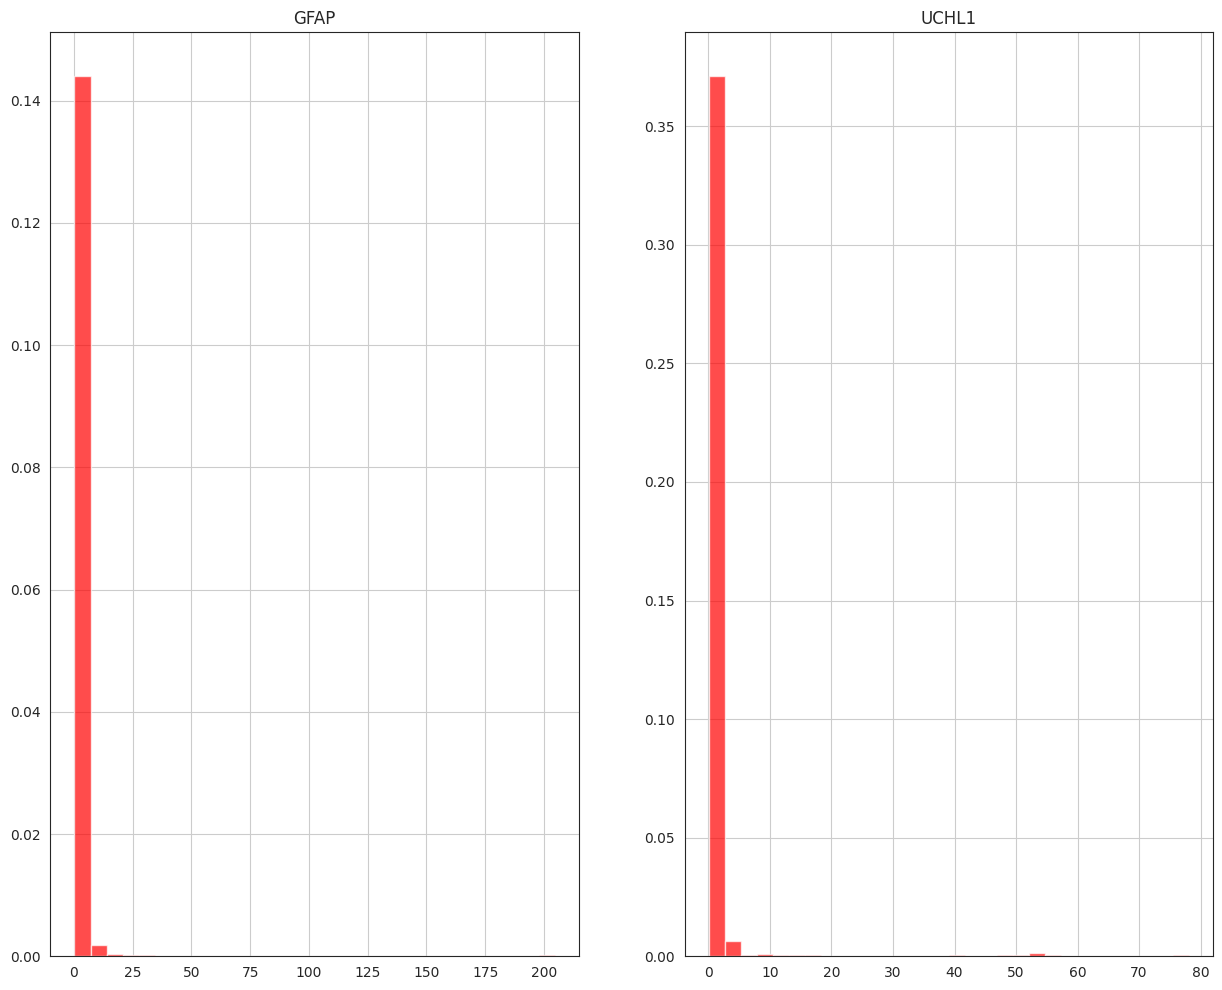

In [402]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 12))

df['GFAP'].hist(bins=30, ax=axes[0], density=True, alpha=0.7, color='red')
df['UCHL1'].hist(bins=30, ax=axes[1], density=True, alpha=0.7, color='red')
axes[0].set_title('GFAP')
axes[1].set_title('UCHL1')
plt.show()

In [403]:
from scipy.stats import zscore

z_scores_g = zscore(df['GFAP'])
outlier_g = abs(z_scores_g) > 2

z_scores_u = zscore(df['UCHL1'])
outlier_u = abs(z_scores_u) > 2

print(f"GFAP Outliers: \n{df['GFAP'][outlier_g]}")
print(f"\nUCHL1 Outliers: \n{df['UCHL1'][outlier_u]}")

GFAP Outliers: 
83      18.000000
456     27.970000
460    204.628736
744     25.850000
Name: GFAP, dtype: float64

UCHL1 Outliers: 
54     47.000000
67     54.000000
68     53.398876
69     52.797753
70     50.393258
94     40.757146
121    15.200000
122    78.100000
123    16.800000
460    56.619318
Name: UCHL1, dtype: float64


In [404]:
#print(f"GFAP outlier patients: \n{df['sample_id'][outlier_g]}\n\nUCHL1 outlier patients: \n{df['sample_id'][outlier_u]}")
print(f"GFAP outlier patients: \n{df['subject_id'][outlier_g]}\n\nUCHL1 outlier patients: \n{df['subject_id'][outlier_u]}")

GFAP outlier patients: 
83     TBI025
456    TBI116
460    TBI116
744    TBI190
Name: subject_id, dtype: object

UCHL1 outlier patients: 
54     TBI018
67     TBI022
68     TBI022
69     TBI022
70     TBI022
94     TBI028
121    TBI036
122    TBI036
123    TBI036
460    TBI116
Name: subject_id, dtype: object


In [405]:
unique_subject_u = df['subject_id'][outlier_u].unique()
unique_subject_g = df['subject_id'][outlier_g].unique()
cleaned_data_u = df[~df['subject_id'].isin(unique_subject_u)]
cleaned_data_g = cleaned_data_u[~cleaned_data_u['subject_id'].isin(unique_subject_g)]
df =cleaned_data_g.copy()

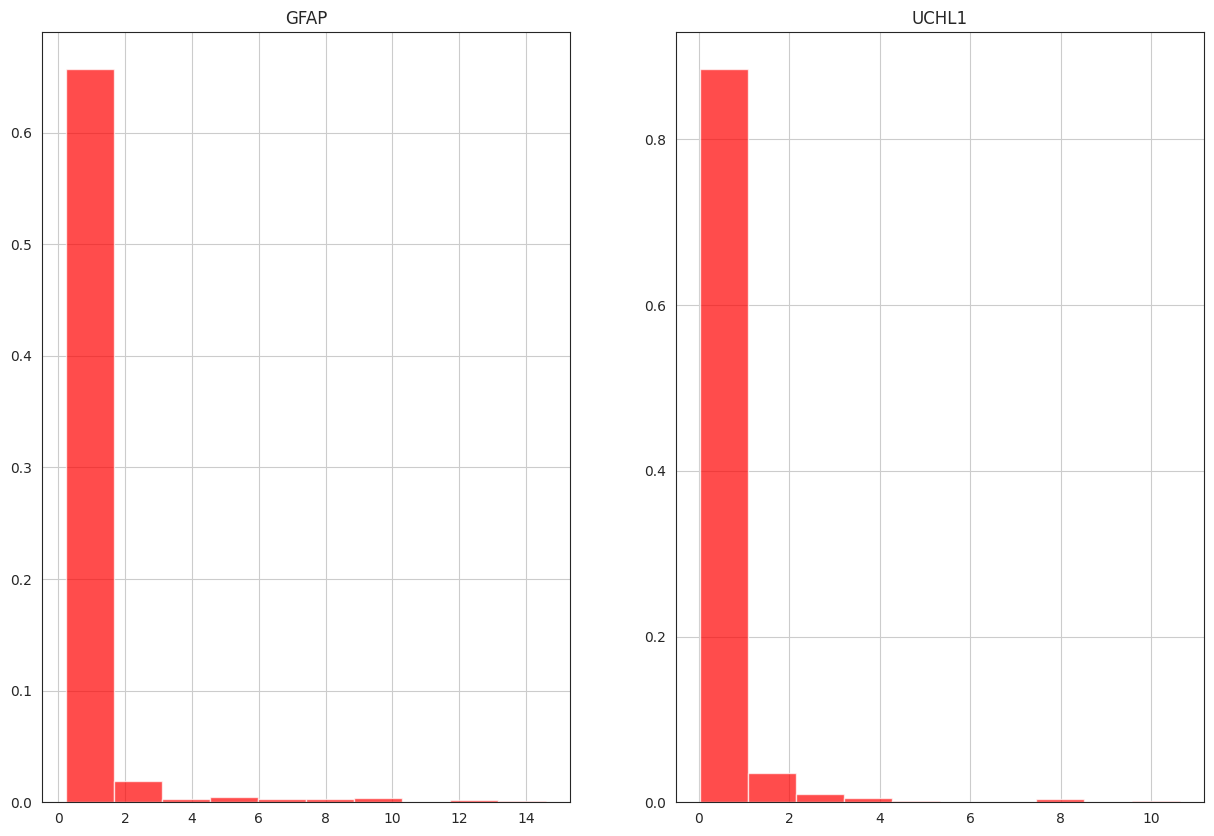

In [406]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 10))

df['GFAP'].hist(bins=10, ax=axes[0], density=True, alpha=0.7, color='red')
df['UCHL1'].hist(bins=10, ax=axes[1], density=True, alpha=0.7, color='red')
axes[0].set_title('GFAP')
axes[1].set_title('UCHL1')
plt.show()

In [407]:
# df = np.loadtxt('../input/datasets-no-interp/full_kf.csv', delimiter = ",",skiprows = 1) # Load data as numpy array and drop column headers
# tickers = pd.read_csv('../input/datasets-no-interp/full_kf.csv', nrows=0).columns.tolist() # Extract column headers

#df = pd.read_csv('../input/data-kfs/long_format.csv') # Load data as numpy array and drop column headers
df = df.drop(columns=['subject_id', 'time_hours'])

# df = pd.read_csv('../input/interpolated-data/interpolated_data.csv') # Load data as numpy array and drop column headers
# df = df.drop(columns=['sample_id', 'time_step'])

tickers = df.columns
df = df.to_numpy()

tickers

Index(['GFAP', 'UCHL1', 'gose', 'age', 'education', 'marshall_grade',
       'pupil_reactivity', 'severity', 'sex'],
      dtype='object')

In [408]:
nn = np.log1p(df[:,  :2])
nm = df[:,  2:]

df = np.concatenate((nn, nm), axis=1)

In [409]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df).astype(np.float32) # Scale data

## Create rolling window sequences

In [410]:
seq_len = 6  # Sliding window
n_seq = len(tickers)    # Number of features
batch_size = 64  # You can change this

In [411]:
# Group the dataset
data = []

#for i in range(len(df) - seq_len):
for i in range(0, len(df), seq_len):
    data.append(scaled_data[i : i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [412]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))              # Slices, shuffles (based on window size) and puts the data in batches (based on batch size)

real_series_iter = iter(real_series.repeat())

## Set up random series generator

In [413]:
# Generate random data from uniform distribution

def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [414]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Components

The design of the TimeGAN components follows the author's sample code.

##  Network Parameters

In [415]:
hidden_dim = 24  # You can change this
num_layers = 3  # You can change this
train_steps = 2000  # Change this
gamma = 1 

In [416]:
# Defining Functions and variable

# Create a basic RNN cell
# def make_rnn(n_layers, hidden_units, output_units, name):
#     return Sequential([GRU(units=hidden_units,
#                            return_sequences=True,
#                            kernel_regularizer=l2(0.001),
#                            name=f'GRU_{i + 1}') for i in range(n_layers)] +
#                       [Dense(units=32,
#                              activation='relu',
#                              name=f'OUT_{i + 1}')] + [Dropout(0.3)] +
#                       [Dense(units=16,
#                              activation='relu',
#                              name=f'OUT_{i + 2}')] + [Dropout(0.3)] +
#                       [Dense(units=output_units,
#                              activation='sigmoid',
#                              name=f'OUT_{i + 3}')], name=name)

def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           kernel_regularizer=l2(0.01),
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name=f'OUT_{i + 3}')], name=name)

# Create model for each function
embedder = make_rnn(n_layers=num_layers, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')

recovery = make_rnn(n_layers=num_layers, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

generator = make_rnn(n_layers=num_layers, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')

discriminator = make_rnn(n_layers=num_layers, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')

supervisor = make_rnn(n_layers=num_layers - 1, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# Loss functions
mse = MeanSquaredError()     # Computes the mean of squares of errors between labels and predictions.
bce = BinaryCrossentropy()   # Computes the cross-entropy loss between true labels and predicted labels.


# Calculate generator loss
def get_generator_moment_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])

    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))

    return g_loss_mean + g_loss_var
    
# Extract test data
def get_real_data():
    df = pd.read_csv('../input/data-kfs/long_format.csv') # Load data as numpy array and drop column headers
    df = df.drop(columns=['subject_id', 'time_hours'])
    # df = pd.read_csv('../input/interpolated-data/interpolated_data.csv')
    # df = df.drop(columns=['sample_id', 'time_step'])
    df = df.to_numpy()
    
    df = df[np.argsort(df[:, 0])]

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    data = []
    
    #for i in range(len(df) - seq_len):
    for i in range(0, len(df), seq_len):
        data.append(scaled_data[i:i + seq_len])

    return data

# Design model for classification task
def get_model():
    model = Sequential([LSTM(int(n_seq/2), input_shape=(seq_len-1, n_seq)),
                        Dense(n_seq)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))

    return model

In [417]:
# Run TimeGAN for several times while simultaneously changing model parameters

all_metric = []

writer = tf.summary.create_file_writer(log_dir.as_posix())   # Creates a summary file writer for the given log directory and puts it in the created path above

os.makedirs('result', exist_ok=True)

parameters = {"hidden_dim":hidden_dim, "num_layers":num_layers, "epochs":train_steps, "seq_len":seq_len, "batch_size":batch_size}
with open("result/parameters.json", "w") as f:
    json.dump(parameters, f, indent=4)

X = Input(shape=[seq_len, n_seq], name='RealData')      # Placeholder for the real data
Z = Input(shape=[seq_len, n_seq], name='RandomData')    # Placeholder for the randomly generated data

# Autoencoder
H = embedder(X)          # Creates latent space for the real data
X_tilde = recovery(H)    # Recreates real data for above latent space

autoencoder = Model(inputs=X, outputs=X_tilde, name='Autoencoder')
autoencoder_optimizer = Adam()


print("\nTraining autoencoder")
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:      # Record operations for automatic differentiation
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)    # Scaling the loss so that the model can notice the variations

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))

    return tf.sqrt(embedding_loss_t0)

# Train step
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

# save autoencoder model
autoencoder.save('result/autoencoder.h5')

    
# Supervisor
E_hat = generator(Z)     # Creates latent space for fake data
H_hat = supervisor(E_hat)     # Creates estimated next Y sequence (for fake data)
Y_fake = discriminator(H_hat)     # Outputs the estimated next Y classification (for fake data)

adversarial_supervised = Model(inputs=Z, outputs=Y_fake, name='AdversarialNetSupervised') 
supervisor_optimizer = Adam()

print("\nTraining supervisor")
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)        # Computes real data latent space
        h_hat_supervised = supervisor(h)     # Computes estimated next sequence (for real data)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, :-1, :])    # Computes loss between actual next sequence and estimated next sequence (for real data)

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))

    return g_loss_s

# Train step
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

# Save model
supervisor.save('result/supervisor.h5')


# Joint training
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

# Adversarial
Y_fake_e = discriminator(E_hat)     # Outputs the next Y classification (for fake data)
adversarial_emb = Model(inputs=Z, outputs=Y_fake_e, name='AdversarialNet')

X_hat = recovery(H_hat)     # Outputs the next fake x data
synthetic_data_model = Model(inputs=Z, outputs=X_hat, name='SyntheticData')

Y_real = discriminator(H)     # Outputs classification of the real data
discriminator_model = Model(inputs=X, outputs=Y_real, name='DiscriminatorReal')


@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)     # Outputs the estimated next Y classification (for fake data)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake), y_pred=y_fake)

        y_fake_e = adversarial_emb(z)     # Outputs the next Y classification (for fake data)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),  y_pred=y_fake_e)

        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data_model(z)     # Outputs the next fake x data
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss


@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x) # Recovered real X
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))

    return tf.sqrt(embedding_loss_t0)


@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)     # Outputs classification of the real data
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)     # Outputs the estimated next Y classification (for fake data)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)     # Outputs the next Y classification (for fake data)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)

    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)


@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))

    return discriminator_loss


print("\nStart Joint Training")
# Group training
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(5):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)

    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

# Save model
synthetic_data_model.save('result/synthetic_data_model.h5')

print("Joint training ended.")


Training autoencoder


100%|██████████| 2000/2000 [00:43<00:00, 46.00it/s]



Training supervisor


100%|██████████| 2000/2000 [00:28<00:00, 70.84it/s] 



Start Joint Training
     0 | d_loss: 2.0262 | g_loss_u: 0.7354 | g_loss_s: 0.0013 | g_loss_v: 0.3791 | e_loss_t0: 0.0782
 1,000 | d_loss: 1.2015 | g_loss_u: 1.4955 | g_loss_s: 0.0007 | g_loss_v: 0.0602 | e_loss_t0: 0.0431
Joint training ended.


In [418]:
# Generate synthetic data
print('\nGenerating synthetic data.')

generated_data = []

for i in range(int(n_windows / batch_size)):
#for i in range(int(n_windows)):
    Z_ = next(random_series)
    d = synthetic_data_model(Z_)
    generated_data.append(d)

# Renormalization

generated_data = np.array(np.vstack(generated_data))

np.save('result/generated_data.npy', generated_data)

# Export synthetic data
generated_data = (scaler.inverse_transform(generated_data.reshape(-1, n_seq)).reshape(-1, seq_len, n_seq))
gen_data = pd.DataFrame(generated_data.reshape(-1, n_seq), columns=tickers)

# gen_data['GFAP'] = np.expm1(gen_data['GFAP'])
# gen_data['UCHL1'] = np.expm1(gen_data['UCHL1'])

gen_data.to_csv('result/synthetic_data.csv', index=False)

print("\nSynthetic data generated!")


Generating synthetic data.

Synthetic data generated!


In [419]:
np.array(data).shape

(124, 6, 9)

Synthetic data shape:  (64, 6, 9)
Real data shape:  (64, 6, 9)

Starting Visualization
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1152 samples in 0.001s...
[t-SNE] Computed neighbors for 1152 samples in 0.049s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1152
[t-SNE] Computed conditional probabilities for sample 1152 / 1152
[t-SNE] Mean sigma: 0.172961
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.907757
[t-SNE] KL divergence after 1000 iterations: 0.254697


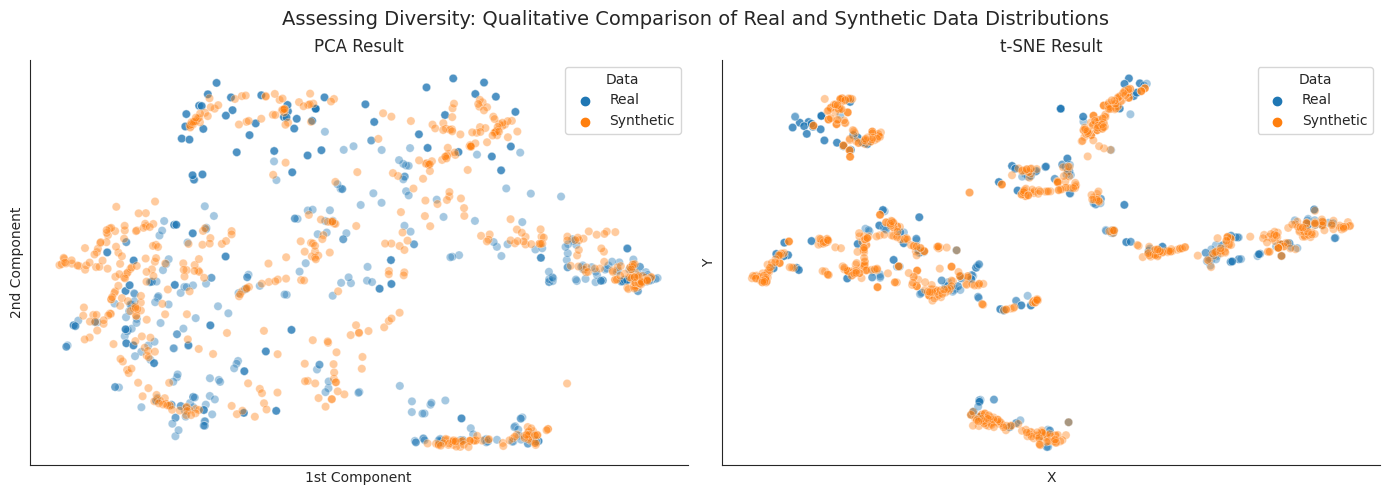

In [420]:
# Evaluating synthetic data
real_data = data

synthetic_data = np.load('result/generated_data.npy')
print("Synthetic data shape: ", synthetic_data.shape)
real_data = np.asarray(real_data)[:synthetic_data.shape[0]]
print("Real data shape: ", real_data.shape)

# Prepare sample
sample_size = len(synthetic_data)
idx = np.random.permutation(len(real_data))[:sample_size]
    
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

    
# Visualization
print("\nStarting Visualization")

## PCA
pca = PCA(n_components=2)
pca.fit(real_sample_2d)

pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
                .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                     .assign(Data='Synthetic'))

pca_result = pd.concat([pca_real, pca_synthetic]).rename(columns={0: '1st Component', 1: '2nd Component'})

## t-SNE
tsne_data = np.concatenate((real_sample_2d,
                        synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
                verbose=1,
                perplexity=50)

tsne_result = tsne.fit_transform(tsne_data)
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

# Plot visual
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                    hue='Data', ax=axes[0], alpha=0.4)
sns.despine()
axes[0].set_title('PCA Result')

sns.scatterplot(x='X', y='Y',
                    data=tsne_result,
                    hue='Data', 
                    ax=axes[1], alpha=0.4)
sns.despine()

for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions', 
                 fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

# Save image
fig.savefig('result/visualization.svg')
plt.show()

In [421]:
def resolve_categories(feature):
    new_feat_val = []
    for i in range(0, len(feature), 6):  # Assuming 6 rows per patient
        feature_values = feature.iloc[i:i+6].round()  # Group for one patient
        
        # Calculate mode
        feat_mode = feature_values.mode()  # Returns a Series
        
        # Handle multiple modes
        if len(feat_mode) > 1:
            feat_mode = feat_mode.min()  # Choose the smallest mode (arbitrary decision)
        else:
            feat_mode = feat_mode[0]  # Single mode
        
        # Create consistent values for all rows
        new_val = [int(feat_mode)] * 6  # Repeat mode for each row of the patient
        new_feat_val.extend(new_val)  # Append to result
    
    return new_feat_val


synthetic_s_data = pd.read_csv('/kaggle/working/result/synthetic_data.csv')
synthetic_d = synthetic_s_data.copy()
synthetic_d['severity'] = resolve_categories(synthetic_d['severity'])
synthetic_d['gose'] = resolve_categories(synthetic_d['gose'])
synthetic_d['age'] = resolve_categories(synthetic_d['age'])
synthetic_d['education'] = resolve_categories(synthetic_d['education'])
synthetic_d['marshall_grade'] = resolve_categories(synthetic_d['marshall_grade'])
synthetic_d['pupil_reactivity'] = resolve_categories(synthetic_d['pupil_reactivity'])
synthetic_d['sex'] = resolve_categories(synthetic_d['sex'])

In [422]:
from scipy.stats import ks_2samp

real_s_data = cleaned_data_g
#real_s_data = pd.read_csv('../input/interpolated-data/interpolated_data.csv')
#real_s_data = real_s_data.drop(columns=['sample_id', 'time_step'])
real_s_data = real_s_data.drop(columns=['subject_id'])
synthetic_s_data = synthetic_d


for feature in tickers:   
    stat, p_value = ks_2samp(real_s_data[feature], synthetic_s_data[feature])
    print(f'\n{feature}: KS test p-value = {p_value}')


GFAP: KS test p-value = 1.292096955299689e-108

UCHL1: KS test p-value = 3.254442729508785e-24

gose: KS test p-value = 0.3261230455169161

age: KS test p-value = 2.6761561701191622e-06

education: KS test p-value = 0.7855280653611068

marshall_grade: KS test p-value = 0.12119646271049424

pupil_reactivity: KS test p-value = 0.9999999999998394

severity: KS test p-value = 0.11666245898195762

sex: KS test p-value = 0.08868476787584773


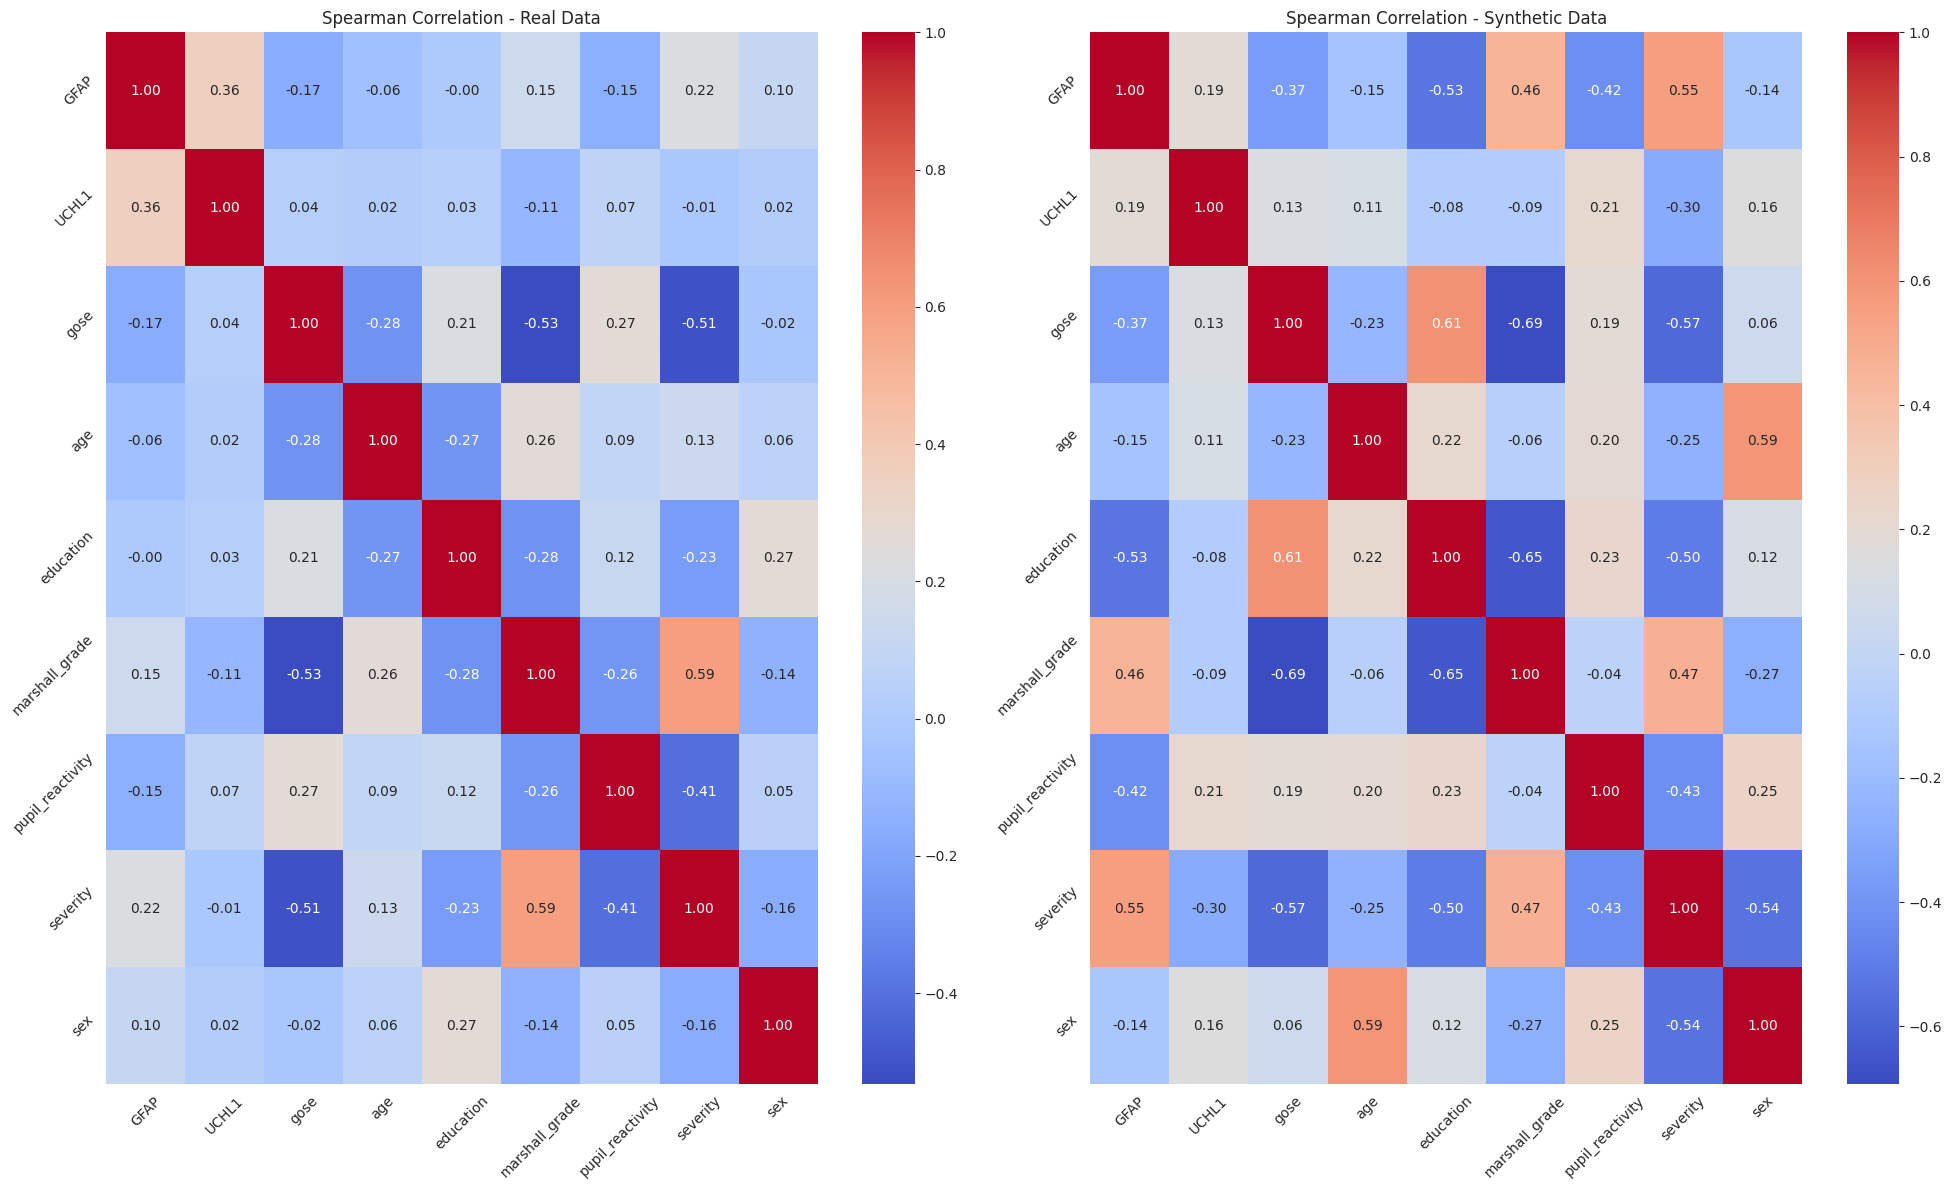

In [423]:
real_s_data = cleaned_data_g.drop(columns=['subject_id', 'time_hours'])
#real_s_data = real_s_data
synthetic_s_data = synthetic_d.copy()

# Compute Spearman correlation for real data
real_corr = real_s_data.corr(method='spearman')

# Compute Spearman correlation for synthetic data
synthetic_corr = synthetic_s_data.corr(method='spearman')

# Plot the heatmaps
fig, axes = plt.subplots(1, 2, figsize=(20, 12))

# Heatmap for real data
sns.heatmap(
    real_corr,
    annot=True,  # Show correlation coefficients
    fmt=".2f",
    cmap='coolwarm',  # Color map
    ax=axes[0]
)
axes[0].set_title('Spearman Correlation - Real Data')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=45)

# Heatmap for synthetic data
sns.heatmap(
    synthetic_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    ax=axes[1]
)
axes[1].set_title('Spearman Correlation - Synthetic Data')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('result/corrplot.svg')
plt.show()

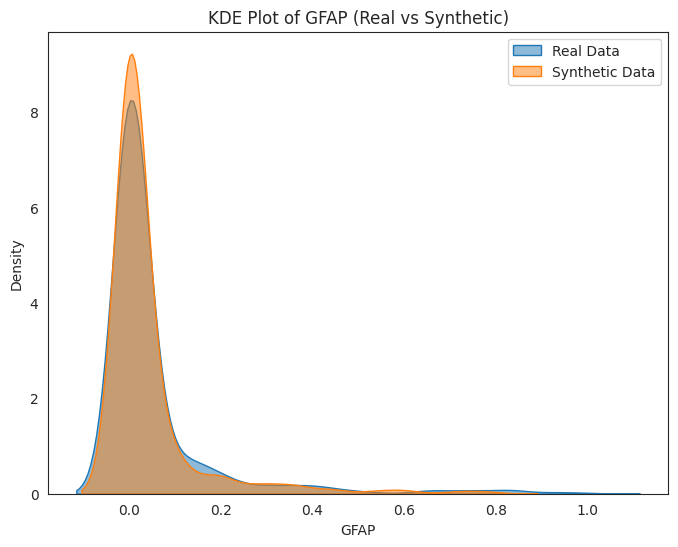

In [424]:
import seaborn as sns

real_data = data
real_data = np.asarray(real_data)
synthetic_data = np.load('result/generated_data.npy')
 
plt.figure(figsize=(8, 6))

# KDE for real data
sns.kdeplot(real_data[:, :, 0:1].flatten(), 
    label='Real Data', 
    color='#1f77b4',
    fill=True, alpha=0.5
)

# KDE for synthetic data
sns.kdeplot(synthetic_data[:, :, 0:1].flatten(), 
    label='Synthetic Data', 
    color='#ff7f0e', 
    fill=True, alpha=0.5
)

# Add labels, title, and legend
plt.xlabel('GFAP')
plt.ylabel('Density')
plt.title('KDE Plot of GFAP (Real vs Synthetic)')
plt.legend()
plt.savefig('result/gfap_kde.svg')
plt.show()

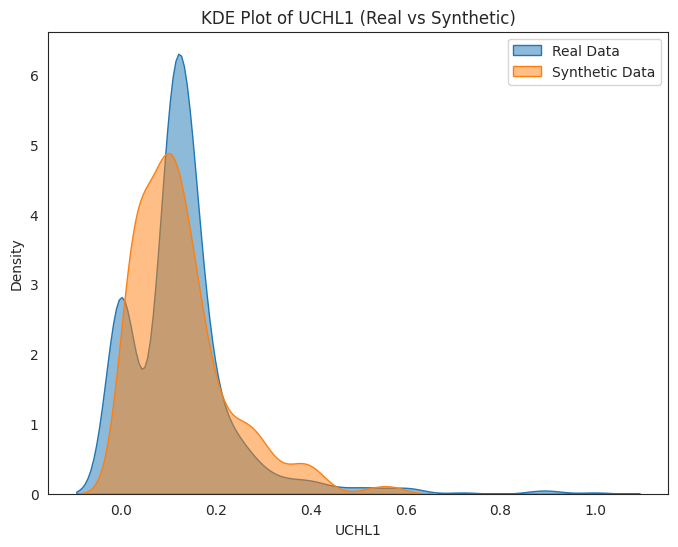

In [425]:
plt.figure(figsize=(8, 6))

# KDE for real data
sns.kdeplot(real_data[:, :, 1:2].flatten(), 
    label='Real Data', 
    color='#1f77b4', 
    fill=True, alpha=0.5
)

# KDE for synthetic data
sns.kdeplot(synthetic_data[:, :, 1:2].flatten(), 
    label='Synthetic Data', 
    color='#ff7f0e', 
    fill=True, alpha=0.5
)

# Add labels, title, and legend
plt.xlabel('UCHL1')
plt.ylabel('Density')
plt.title('KDE Plot of UCHL1 (Real vs Synthetic)')
plt.legend()
plt.savefig('result/uchl1_kde.svg')
plt.show()

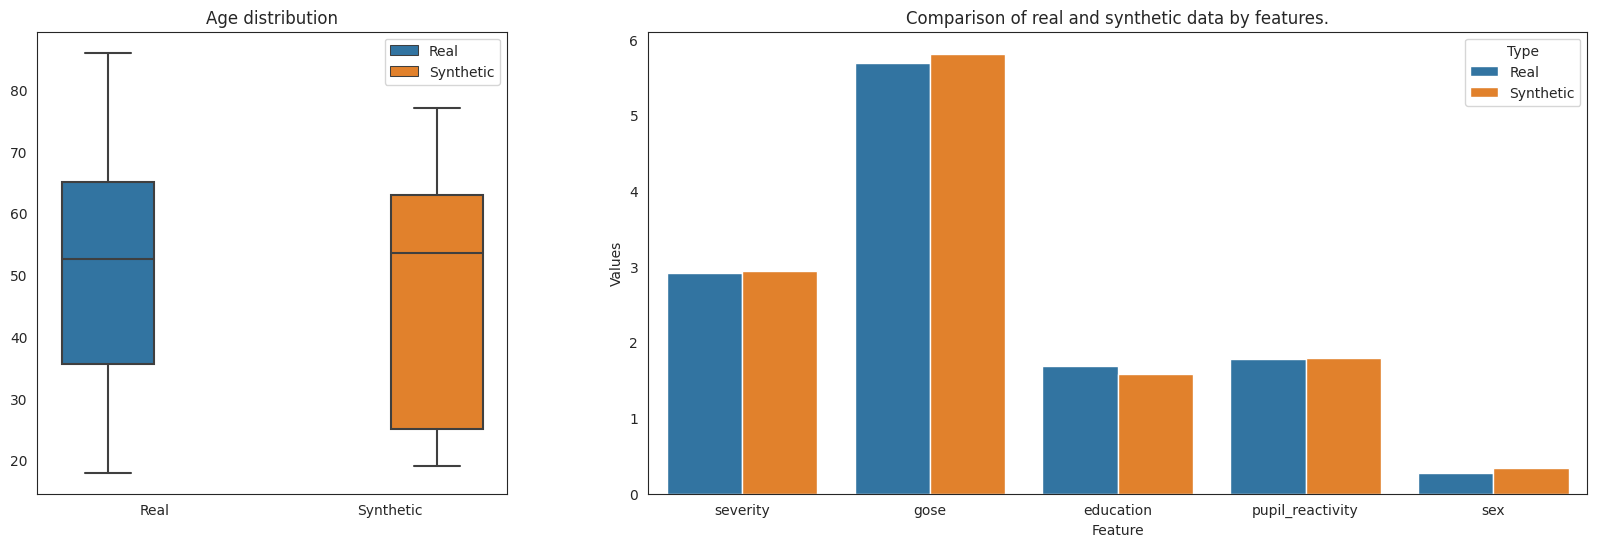

In [426]:
real_s_data = real_s_data
synthetic_s_data = synthetic_d.copy()

data1 = {
    'Type': ['Real'] * len(real_s_data) + ['Synthetic'] * len(synthetic_s_data),
    'severity': np.concatenate([real_s_data['severity'], synthetic_s_data['severity']]),
    'gose': np.concatenate([real_s_data['gose'], synthetic_s_data['gose']]),
    'education': np.concatenate([real_s_data['education'], synthetic_s_data['education']]),
    'pupil_reactivity': np.concatenate([real_s_data['pupil_reactivity'], synthetic_s_data['pupil_reactivity']]),
    'sex': np.concatenate([real_s_data['sex'], synthetic_s_data['sex']])                                                          
}

['GFAP', 'UCHL1', 'gose', 'age', 'education', 'marshall_grade',
       'pupil_reactivity', 'severity', 'sex']

df = pd.DataFrame(data1)

data2 = {
    'Type': ['Real'] * len(real_s_data) + ['Synthetic'] * len(synthetic_s_data),
    'age': np.concatenate([real_s_data['age'], synthetic_s_data['age']])
}

df_long = pd.melt(df, id_vars=['Type'], var_name='Feature', value_name="value")
fig, axes = plt.subplots(1, 2, figsize=(20, 6), gridspec_kw={'width_ratios': [1, 2]})
                         
#plt.figure(figsize=(20, 6))
sns.boxplot(data=data2, x='Type', y='age', ax=axes[0], hue='Type')
axes[0].set_title("Age distribution")
sns.barplot(data=df_long, x='Feature', y='value', hue='Type', ax=axes[1], ci=None)
plt.title('Comparison of real and synthetic data by features.')
plt.ylabel("Values")
plt.savefig('result/barplot.svg')
plt.show()


Starting data fidelity
1/1 - 0s - 29ms/step - AUC: 0.6953 - accuracy: 0.5769 - loss: 0.6698
Discriminative score:  0.07692307233810425


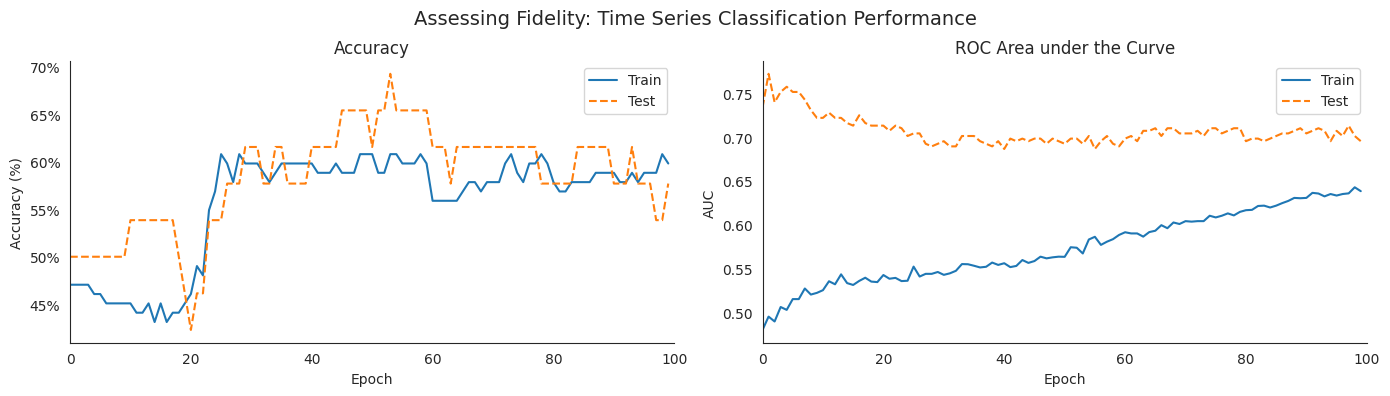

In [427]:
# Data fidelity
print("\nStarting data fidelity")

## Discrimination
real_data = data
real_data = np.array(real_data)[:len(synthetic_data)]
synthetic_data = np.array(synthetic_data)

n_series = synthetic_data.shape[0]
idx = np.arange(n_series)

n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

train_data = np.vstack((real_data[train_idx], synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx], synthetic_data[test_idx]))

n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train), np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test), np.zeros(n_test)))

# Create classifier
epoch = 100
ts_classifier = Sequential([LSTM(int(n_seq/2), input_shape=(seq_len, n_seq), name='GRU'),
                        Dense(1, activation='sigmoid', name='OUT')],
                       name='Time_Series_Classifier')

ts_classifier.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=[AUC(name='AUC'), 'accuracy'])

result = ts_classifier.fit(x=train_data,
                       y=train_labels,
                       validation_data=(test_data, test_labels),
                       epochs=epoch,
                       batch_size=24,
                       verbose=0)

loss, auc, acc = ts_classifier.evaluate(x=test_data, y=test_labels, verbose=2)
all_metric.append([loss, auc, acc, acc-0.5])
#print(loss, auc, acc)
print("Discriminative score: ", acc-0.5)

history = pd.DataFrame(result.history)

# Plot
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1], 
                                                                                         title='ROC Area under the Curve',
                                                                                        style=['-', '--'],
                                                                                        xlim=(0, epoch))

history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0], 
                                                                                                             title='Accuracy',
                                                                                                            style=['-', '--'],
                                                                                                            xlim=(0, epoch))

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()

fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# save plots
fig.savefig('result/fidelity.svg')
plt.show()


Starting TSTR
Test on Synthetic Train on Real (Error):  0.24254676058888436
Test on Real Train on Real (Error):  0.21997924521565437


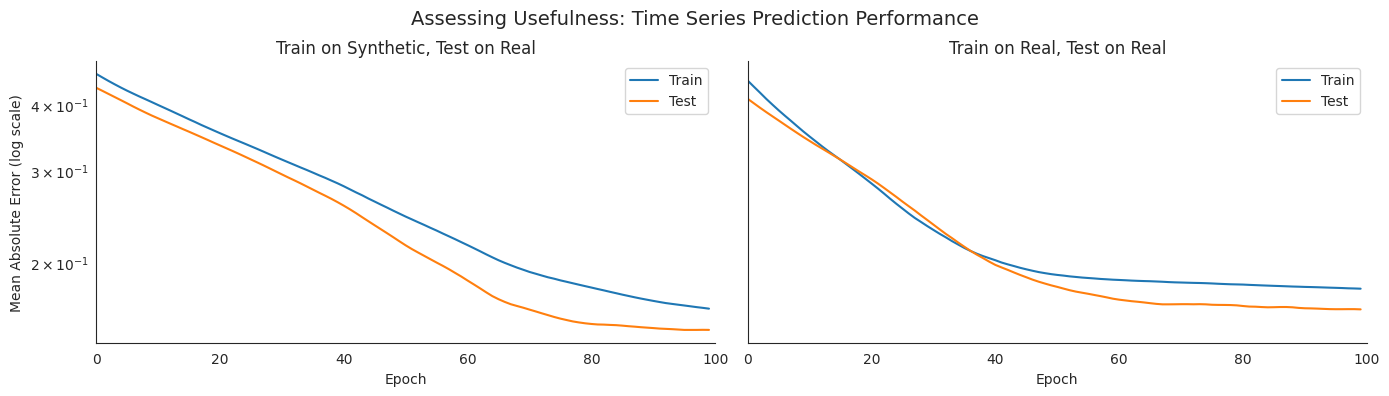

In [428]:
# TSTR
print("\nStarting TSTR")

## Predictive
real_data = data
real_data = np.array(real_data)[:len(synthetic_data)]
synthetic_data = synthetic_data

real_train_data = real_data[train_idx, :seq_len - 1, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :seq_len - 1, :]
real_test_label = real_data[test_idx, -1, :]

synthetic_train = synthetic_data[:, :seq_len - 1, :]
synthetic_label = synthetic_data[:, -1, :]

# print(f'real_train_data: {real_train_data.shape}')
# print(f'real_train_label: {real_train_label.shape}')

# print(f'real_test_data: {real_test_data.shape}')
# print(f'real_test_label: {real_test_label.shape}')

# print(f'synthetic_train: {synthetic_train.shape}')
# print(f'synthetic_label: {synthetic_label.shape}')

# Call classifier model
epoch = 100
ts_regression = get_model()

synthetic_result = ts_regression.fit(x=synthetic_train,
                                         y=synthetic_label,
                                         validation_data=(
                                             real_test_data, 
                                             real_test_label),
                                         epochs=epoch,
                                         batch_size=24,
                                         verbose=0)

ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                    y=real_train_label,
                                    validation_data=(
                                        real_test_data, 
                                        real_test_label),
                                    epochs=epoch,
                                    batch_size=24,
                                    verbose=0)

synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train', 'val_loss': 'Test'})

print("Test on Synthetic Train on Real (Error): ", synthetic_result['Test'].mean())
print("Test on Real Train on Real (Error): ", real_result['Test'].mean())

all_metric.append([synthetic_result['Test'].mean(), real_result['Test'].mean()])

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)
synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real', logy=True, xlim=(0, epoch))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real', logy=True, xlim=(0, epoch))

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

# save plot
fig.savefig('result/TSTR.svg')
plt.show()


# Clear session
tf.keras.backend.clear_session(free_memory=True)

In [429]:
# Export metrics

with open("evaluation_results.json", "w") as file:
    json.dump(all_metric, file, indent=4)

# Mortality

In [430]:
def get_data(df):

    data = []
    
    for i in range(0, len(df), seq_len):
        data.append(df[i:i + seq_len])

    return data

In [431]:
# Extract synthetic data
synthetic_table = pd.read_csv('/kaggle/working/result/synthetic_data.csv')

print('min gfap = ', synthetic_table['GFAP'].min())
print('max gfap = ', synthetic_table['GFAP'].max())

print('\nmin uchl1 = ',synthetic_table['UCHL1'].min())
print('max uchl1 = ', synthetic_table['UCHL1'].max())

min gfap =  0.19967026
max gfap =  2.2083843

min uchl1 =  0.036740847
max uchl1 =  1.4150227


In [432]:
from scipy.stats import mode

# Split to train and test

# real_table = pd.read_csv('../input/interpolated-data/interpolated_data.csv')
# real_table = real_table.drop(columns=['sample_id', 'time_step'])
real_table = pd.read_csv('../input/data-kfs/long_format.csv')
real_table = real_table.drop(columns=['subject_id', 'time_hours'])

# Test data
X_real_test = real_table.drop(columns=['gose'])
X_real_test = np.array(get_data(X_real_test))
X_real_test = np.array(X_real_test)

y_real_label = [1 if value == 1 else 0 for value in real_table['gose']]
y_real_label = np.array(get_data(y_real_label))
y_real_label = y_real_label[:, 0]

# Train data
X_synthetic_train = synthetic_table.drop(columns=['gose'])
X_synthetic_train = np.array(get_data(X_synthetic_train))

y_synthetic_label = [1 if value <= 1.5 else 0 for value in synthetic_table['gose']]
y_synthetic_label = np.array(get_data(y_synthetic_label))
y_synthetic_label = mode(y_synthetic_label, axis=1)[0].flatten()

print(f"test_data has shape: {X_real_test.shape}")
print(f"test_label has shape: {y_real_label.shape}")
print(f"train_data has shape: {X_synthetic_train.shape}")
print(f"train_label has shape: {y_synthetic_label.shape}")

test_data has shape: (131, 6, 8)
test_label has shape: (131,)
train_data has shape: (64, 6, 8)
train_label has shape: (64,)


In [433]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_synthetic_train.reshape(X_synthetic_train.shape[0], -1), y_synthetic_label)  # Real data features (X_real) and GOSE labels (y_real)
predictions = clf.predict(X_real_test.reshape(X_real_test.shape[0], -1))
predictions

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [434]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print("Using 100% Synthetic to train and 100% Real to test")
print("\nAccuracy: ", accuracy_score(y_real_label, predictions))

pred_prob = clf.predict_proba(X_real_test.reshape(X_real_test.shape[0], -1))[:,1]
pred_prob = np.array(pred_prob)
y_real_label_new = np.array(y_real_label)
roc_auc = roc_auc_score(y_real_label_new, pred_prob)
print("ROC-AUC: ", roc_auc)

Using 100% Synthetic to train and 100% Real to test

Accuracy:  0.916030534351145
ROC-AUC:  0.9312255541069101


## Adding 20 percent of the real to synthetic for training

In [435]:
n_series = X_real_test.shape[0]
idx = np.arange(n_series)

n_train = int(.2*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

train_data = np.vstack((X_real_test[train_idx], X_synthetic_train))
test_data = X_real_test[test_idx]

train_label = np.vstack((y_real_label[train_idx].reshape(-1, 1), y_synthetic_label.reshape(-1, 1)))
test_label = y_real_label[test_idx]

test_label

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

In [436]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(train_data.reshape(train_data.shape[0], -1), train_label)  # Real data features (X_real) and GOSE labels (y_real)
predictions = clf.predict(test_data.reshape(test_data.shape[0], -1))
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0])

In [437]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print("Using 100% Synthetic + 20% Real to train and 80% Real to test")
print("\nAccuracy: ", accuracy_score(test_label, predictions))

pred_prob = clf.predict_proba(test_data.reshape(test_data.shape[0], -1))[:, 1]
pred_prob = np.array(pred_prob)
y_real_label_new = np.array(test_label)
roc_auc = roc_auc_score(y_real_label_new, pred_prob)
print("ROC-AUC: ", roc_auc)

Using 100% Synthetic + 20% Real to train and 80% Real to test

Accuracy:  0.8952380952380953
ROC-AUC:  0.8853092783505154


## Using KMeans for mortality of synthetic data

In [438]:
from sklearn.cluster import KMeans

kmeans =KMeans(n_clusters=2, random_state=42)
y_synthetic_label = kmeans.fit_predict(X_synthetic_train.reshape(X_synthetic_train.shape[0], -1))

y_synthetic_label = (y_synthetic_label == 0).astype(int)

In [439]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_synthetic_train.reshape(X_synthetic_train.shape[0], -1), y_synthetic_label)  # Real data features (X_real) and GOSE labels (y_real)
predictions = clf.predict(X_real_test.reshape(X_real_test.shape[0], -1))
predictions

array([1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [440]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

print("Accuracy: ", accuracy_score(y_real_label, predictions))

pred_prob = clf.predict_proba(X_real_test.reshape(X_real_test.shape[0], -1))[:, 1]
pred_prob = np.array(pred_prob)
y_real_label_new = np.array(y_real_label)
roc_auc = roc_auc_score(y_real_label_new, pred_prob)
print("ROC-AUC: ", roc_auc)

Accuracy:  0.5419847328244275
ROC-AUC:  0.613754889178618


In [441]:
#!rm -rf /kaggle/working/*

###### 